## Importing libs

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
sns.set() # apply the seaborn defaults to plotted figures (e.g. theme, scaling, color palette), instead of matplotlib's

In [3]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

2.0.0


In [4]:
import warnings
from time import time, strftime

In [5]:
strftime('%X')

'16:51:22'

## Preparing the Fashion-MNIST dataset
[Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) is a dataset of Zalando’s article images, consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28×28 grayscale image, associated with a label from 10 classes.

**NOTE:** you should have the .csv files in the directory listed below

In [6]:
# confirm that you have fashion-mnist_train.csv and fashion-mnist_test.csv (unzipped)
!ls ../fashion-mnist-dataset/

fashion-mnist_test.csv
fashion-mnist_train.csv
README.txt


In [7]:
PATH_TO_DATA = os.path.join("..", "fashion-mnist-dataset")

# the datasets have the label on the first column and the image pixels on the following 784
train_dataset_csv = pd.read_csv(os.path.join(PATH_TO_DATA, "fashion-mnist_train.csv"), delimiter=',')
test_dataset_csv = pd.read_csv(os.path.join(PATH_TO_DATA, "fashion-mnist_test.csv"), delimiter=',')

In [8]:
IMG_WIDTH = IMG_HEIGHT = 28
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH) # grayscale images
IMG_FLAT_SHAPE = (IMG_HEIGHT*IMG_WIDTH, )

CLASS_NAME = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
              'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
CLASS_COUNT = len(CLASS_NAME)

## Split train into train + validation

In [9]:
# random seed for splitting the data deterministically
RANDOM_SEED = 886
np.random.seed(RANDOM_SEED)

In [10]:
from sklearn.model_selection import train_test_split

train_dataset, validation_dataset = train_test_split(train_dataset_csv, train_size=0.8, shuffle=True, random_state=RANDOM_SEED)
print(f"train:      {train_dataset.shape}") # 80%
print(f"validation: {validation_dataset.shape}") # 20%

test_dataset = test_dataset_csv
print(f"test:       {test_dataset.shape}")

train:      (48000, 785)
validation: (12000, 785)
test:       (10000, 785)


## Separate labels and images

In [11]:
ys_train = train_dataset["label"].values
ys_val   = validation_dataset["label"].values
ys_test  = test_dataset["label"].values

print(ys_train.shape, "min:", ys_train.min(), "max:", ys_train.max())
print(ys_val.shape,   "min:", ys_val.min(),   "max:", ys_val.max())
print(ys_test.shape,  "min:", ys_test.min(),  "max:", ys_test.max())

(48000,) min: 0 max: 9
(12000,) min: 0 max: 9
(10000,) min: 0 max: 9


In [12]:
xs_train = train_dataset.loc[:, train_dataset.columns != "label"].values
xs_val   = validation_dataset.loc[:, validation_dataset.columns != "label"].values
xs_test  = test_dataset.loc[:, test_dataset.columns != "label"].values

print(xs_train.shape, "min:", xs_train.min(), "max:", xs_train.max())
print(xs_val.shape,   "min:", xs_val.min(),   "max:", xs_val.max())
print(xs_test.shape,  "min:", xs_test.min(),  "max:", xs_test.max())

(48000, 784) min: 0 max: 255
(12000, 784) min: 0 max: 255
(10000, 784) min: 0 max: 255


In [13]:
def each_count(array):
    count = np.bincount(array)
    nonzero_count = np.nonzero(count)[0]
    return zip(nonzero_count, count[nonzero_count])

In [14]:
class_count_train = list(each_count(ys_train))
class_count_val   = list(each_count(ys_val))
class_count_test  = list(each_count(ys_test))
print("              Train         Validation    Test")
for label in range(CLASS_COUNT):
    print(f"{(CLASS_NAME[label] + ':'):<12}  "
          f"{class_count_train[label][1]} ({class_count_train[label][1] / ys_train.shape[0]:.2f}%)  "
          f"{class_count_val[label][1]} ({class_count_val[label][1] / ys_val.shape[0]:.2f}%)  "
          f"{class_count_test[label][1]} ({class_count_test[label][1] / ys_test.shape[0]:.2f}%)")

              Train         Validation    Test
T-shirt/top:  4863 (0.10%)  1137 (0.09%)  1000 (0.10%)
Trouser:      4795 (0.10%)  1205 (0.10%)  1000 (0.10%)
Pullover:     4817 (0.10%)  1183 (0.10%)  1000 (0.10%)
Dress:        4770 (0.10%)  1230 (0.10%)  1000 (0.10%)
Coat:         4820 (0.10%)  1180 (0.10%)  1000 (0.10%)
Sandal:       4769 (0.10%)  1231 (0.10%)  1000 (0.10%)
Shirt:        4771 (0.10%)  1229 (0.10%)  1000 (0.10%)
Sneaker:      4764 (0.10%)  1236 (0.10%)  1000 (0.10%)
Bag:          4778 (0.10%)  1222 (0.10%)  1000 (0.10%)
Ankle boot:   4853 (0.10%)  1147 (0.10%)  1000 (0.10%)


## Normalize images and one-hot encode labels

In [15]:
xs_train = xs_train.astype('float32') / 255.0
xs_val   = xs_val.astype('float32')   / 255.0
xs_test  = xs_test.astype('float32')  / 255.0

**Let's forget about the test set for now..** just assume it doesn't exist (but don't worry, we'll come back to it at the end).

In [16]:
print(f"xs_train: mean={xs_train.mean():>8.4f}, stddev={xs_train.std():>7.4f}")

# NOTE that we must use stats from train data to normalize the val and test sets aswell
mean, std = xs_train.mean(), xs_train.std()
X_train = (xs_train - mean) / std

print(f"X_train:  mean={X_train.mean():>8.4f}, stddev={X_train.std():>7.4f}")

xs_train: mean=  0.2862, stddev= 0.3529
X_train:  mean=  0.0000, stddev= 1.0000


In [17]:
X_val = (xs_val - mean) / std
print(f"xs_val: mean={xs_val.mean():>8.4f}, stddev={xs_val.std():>7.4f}")
print(f"X_val:  mean={X_val.mean():>8.4f}, stddev={X_val.std():>7.4f}") # mean should be close to 0 and stddev close to 1

xs_val: mean=  0.2858, stddev= 0.3526
X_val:  mean= -0.0011, stddev= 0.9992


In [18]:
def onehot_encode(ys):
    n_examples, *_ = ys.shape
    onehot = np.zeros(shape=(n_examples, CLASS_COUNT))
    onehot[np.arange(n_examples), ys] = 1
    return onehot

In [19]:
Y_train = onehot_encode(ys_train)
print(ys_train.shape, Y_train.shape)

(48000,) (48000, 10)


In [20]:
Y_val = onehot_encode(ys_val)
print(ys_val.shape, Y_val.shape)

(12000,) (12000, 10)


_obs.:_ `Y_foo` is only a one-hot encoded version of `ys_foo` (so we use `ys_foo` in some places below, to avoid calling `np.argmax`)

## Add helper functions

In [21]:
def plot_history(history, model=None, n_epochs=None, batch_size=None, title_prefix=None):
    plot_title = ("" if title_prefix is None else (title_prefix + "\n")) + "Train history"
    info = []
    if n_epochs is not None:
        info.append(f"{n_epochs} epochs")
    if batch_size is not None:
        info.append(f"{batch_size} batch size")
    if model is not None:
        info.append(f"{model.optimizer.get_config()['name']} optimizer")
    if len(info) > 0:
        plot_title += f" ({', '.join(info)})"
    
    # leave only "loss" and "val_loss" for plotting
    loss_data = pd.DataFrame({k: v for k, v in history.items() if (k == "loss" or k == "val_loss")})
    loss_data.index += 1 # start counting the epochs at 1, not 0
    lineplot = sns.lineplot(data=loss_data)
    lineplot.set_title(plot_title)
    lineplot.set_xlabel("epoch")
    lineplot.set_ylabel("Loss" + f" ({model.loss})" if model is not None else "")
    plt.show()

    # leave only "accuracy" and "val_accuracy" for plotting
    acc_data = pd.DataFrame({k: v for k, v in history.items() if (k == "accuracy" or k == "val_accuracy")})
    acc_data.index += 1 # start counting the epochs at 1, not 0
    lineplot = sns.lineplot(data=acc_data)
    lineplot.set_title(plot_title)
    lineplot.set_xlabel("epoch")
    lineplot.set_ylabel("Accuracy")
    plt.show()

In [22]:
def plot_image_with_prediction(xs, ys, ys_pred, num_rows=5, num_cols=3):
    # ref.: https://www.tensorflow.org/tutorials/keras/classification
    
    def plot_image(i, predictions_array, true_label, img):
        true_label, img = true_label[i], img[i]
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(img.reshape(IMG_SHAPE), cmap=plt.cm.binary)
        predicted_label = np.argmax(predictions_array)
        color = 'blue' if predicted_label == true_label else 'red'
        plt.xlabel("{} {:2.0f}% ({})".format(CLASS_NAME[predicted_label],
                                             100*np.max(predictions_array),
                                             CLASS_NAME[true_label]),
                                             color=color)

    def plot_value_array(i, predictions_array, true_label):
        true_label = true_label[i]
        plt.grid(False)
        plt.xticks(range(10))
        plt.yticks([])
        thisplot = plt.bar(range(10), predictions_array, color="#777777")
        plt.ylim([0, 1])
        predicted_label = np.argmax(predictions_array)
        thisplot[predicted_label].set_color('red')
        thisplot[true_label].set_color('blue')
    
    # plot the first few test images, their predicted labels, and the true labels
    # color correct predictions in blue and incorrect predictions in red    
    num_images = num_rows * num_cols
    plt.figure(figsize=(4 * num_cols, 2 * num_rows))
    for i in range(num_images):
        plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
        plot_image(i, ys_pred[i], ys, xs)
        plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
        plot_value_array(i, ys_pred[i], ys)
    plt.tight_layout()
    plt.show()

In [23]:
from sklearn.metrics import confusion_matrix, f1_score

In [24]:
def print_cm(ys, ys_pred, class_names, figsize=(10, 9), fontsize=12):
    #cm = confusion_matrix(ys, ys_pred)
    #df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    cm = np.flip(confusion_matrix(ys, ys_pred), axis=0)
    df_cm = pd.DataFrame(cm, index=class_names[::-1], columns=class_names)
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    heatmap.set_ylim(*heatmap.get_xlim())
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

## 1. Baseline
Explore Neural Networks with Fashion-MNIST. What is the accuracy? Describe your Neural Network architecture.

In [25]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Reshape
from tensorflow.keras.regularizers import l1, l2

In [26]:
MAX_EPOCHS = 64
BATCH_SIZE = 512
TF_VERBOSE = 1 # 0 = silent, 1 = progress bar, 2 = one line per epoch

In [27]:
def train(model, X_train, Y_train, X_val, Y_val, n_epochs=MAX_EPOCHS, batch_size=BATCH_SIZE, 
          min_delta=0.003, patience=3, early_stopping=True, plot_title=None, plot=True):
    best_model_path = os.path.join("models", f"best_model_{model.name}.h5")
    if not os.path.exists(os.path.dirname(best_model_path)):
        os.makedirs(os.path.dirname(best_model_path))
    
    callbacks = ([keras.callbacks.ModelCheckpoint(monitor='val_loss', filepath=best_model_path, save_best_only=True)]
                 if not early_stopping else
                 [keras.callbacks.ModelCheckpoint(monitor='val_loss', filepath=best_model_path, save_best_only=True),
                  keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=min_delta, patience=patience)])
    
    print("Starting to train...")
    start = time()
    hist = model.fit(
        x=X_train, y=Y_train,
        validation_data=(X_val, Y_val),
        epochs=n_epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=TF_VERBOSE
    ).history
    end = time()
    print(f"\nDone.\nTraining took {(end - start):.2f}s")
    
    if os.path.exists(best_model_path):
        model = keras.models.load_model(best_model_path)
    
    if plot:
        plot_history(hist, model, n_epochs, batch_size, plot_title)
    
    return hist, model

## 1.1. MLP

In [48]:
model = keras.Sequential([
    Input(IMG_FLAT_SHAPE), # 28 * 28 = 784 pixels
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax', kernel_regularizer=l2(0.001))
], "MLP_baseline")

In [29]:
# NOTE use 'categorical_crossentropy' since `labels` is a one-hot encoded vector
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [30]:
model.summary()

Model: "MLP_baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


In [31]:
model.optimizer.get_config()

{'name': 'Adam',
 'learning_rate': 0.001,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

In [32]:
strftime('%X')

'16:54:27'

Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 9s 180us/sample - loss: 0.6578 - accuracy: 0.7732 - val_loss: 0.4680 - val_accuracy: 0.8352
Epoch 2/64
48000/48000 [==============================] - 8s 162us/sample - loss: 0.4250 - accuracy: 0.8540 - val_loss: 0.4159 - val_accuracy: 0.8540
Epoch 3/64
48000/48000 [==============================] - 9s 184us/sample - loss: 0.3814 - accuracy: 0.8695 - val_loss: 0.3772 - val_accuracy: 0.8712
Epoch 4/64
48000/48000 [==============================] - 9s 179us/sample - loss: 0.3520 - accuracy: 0.8794 - val_loss: 0.3650 - val_accuracy: 0.8725
Epoch 5/64
48000/48000 [==============================] - 9s 194us/sample - loss: 0.3319 - accuracy: 0.8853 - val_loss: 0.3571 - val_accuracy: 0.8759
Epoch 6/64
48000/48000 [==============================] - 8s 172us/sample - loss: 0.3137 - accuracy: 0.8923 - val_loss: 0.3777 - val_accuracy: 0.8658
Epoch 7/64
48000/48000 [=====

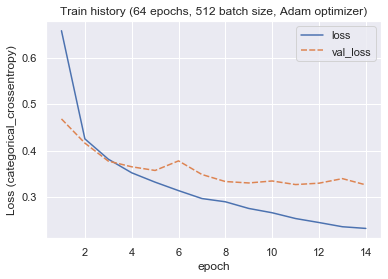

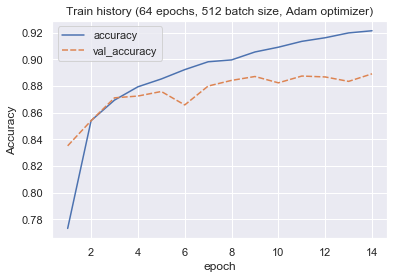

In [33]:
history, best_model = train(model, X_train, Y_train, X_val, Y_val)

In [34]:
strftime('%X')

'16:56:27'

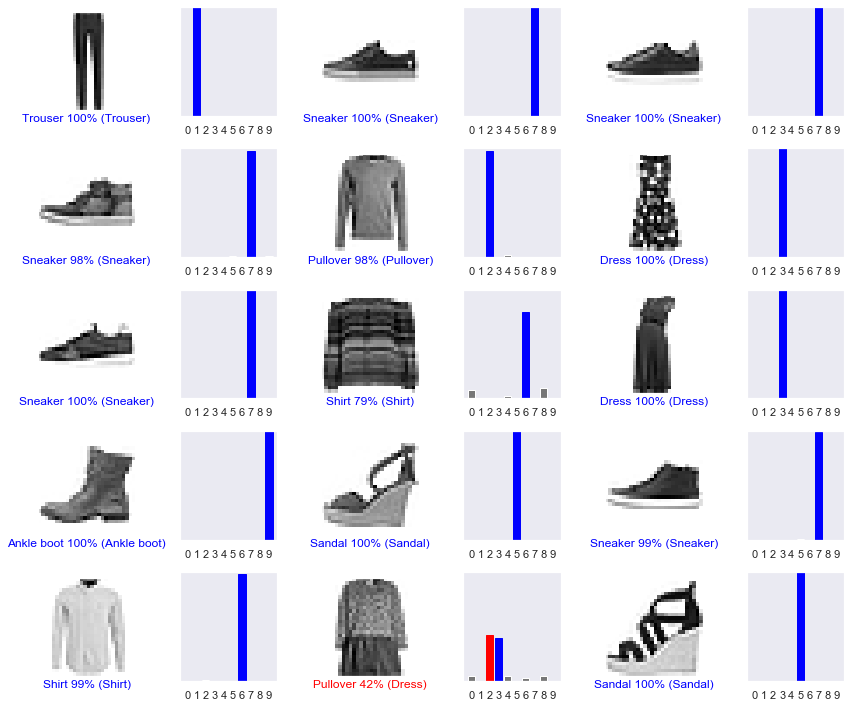

In [35]:
Y_val_pred = best_model.predict(X_val)
plot_image_with_prediction(X_val, ys_val, Y_val_pred)

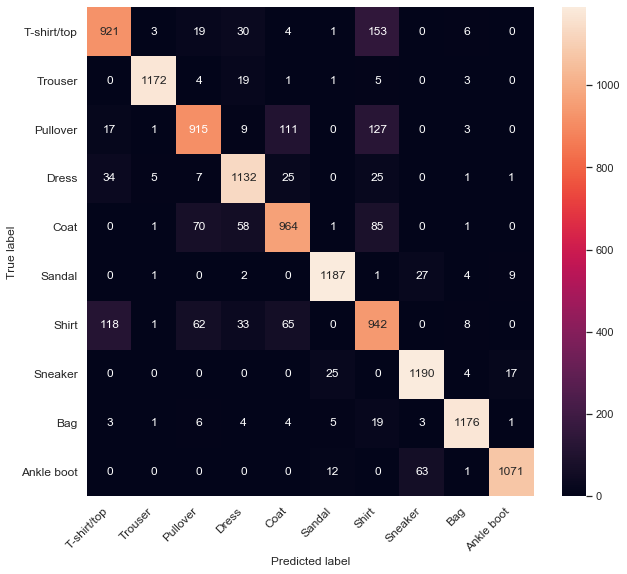

In [36]:
print_cm(ys_val, np.argmax(Y_val_pred, axis=1), CLASS_NAME)

## 1.2. CNN

In [37]:
# obs.: padding='valid' by default (i.e. no padding)
conv_model = keras.Sequential([
    Reshape((28, 28, 1), input_shape=(784,)),
    Conv2D(32, (5, 5), activation='relu', padding='same', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)), # 28x28 -> 14x14 feature map
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)), # 14x14 -> 7x7 feature map
    Flatten(), # 7*7*64 = 3136
    Dense(10, activation='softmax', kernel_regularizer=l2(0.001))
], "CNN_baseline")

In [38]:
conv_model.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

In [39]:
conv_model.summary()

Model: "CNN_baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)               

In [40]:
conv_model.optimizer.get_config()

{'name': 'Adam',
 'learning_rate': 0.001,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

In [41]:
strftime('%X')

'16:56:57'

Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 3s 67us/sample - loss: 0.7333 - accuracy: 0.7573 - val_loss: 0.4751 - val_accuracy: 0.8338
Epoch 2/64
48000/48000 [==============================] - 2s 42us/sample - loss: 0.4370 - accuracy: 0.8533 - val_loss: 0.4025 - val_accuracy: 0.8671
Epoch 3/64
48000/48000 [==============================] - 2s 37us/sample - loss: 0.3866 - accuracy: 0.8719 - val_loss: 0.3693 - val_accuracy: 0.8789
Epoch 4/64
48000/48000 [==============================] - 2s 39us/sample - loss: 0.3561 - accuracy: 0.8839 - val_loss: 0.3498 - val_accuracy: 0.8870
Epoch 5/64
48000/48000 [==============================] - 2s 39us/sample - loss: 0.3335 - accuracy: 0.8906 - val_loss: 0.3381 - val_accuracy: 0.8868
Epoch 6/64
48000/48000 [==============================] - 2s 40us/sample - loss: 0.3239 - accuracy: 0.8946 - val_loss: 0.3313 - val_accuracy: 0.8934
Epoch 7/64
48000/48000 [===========

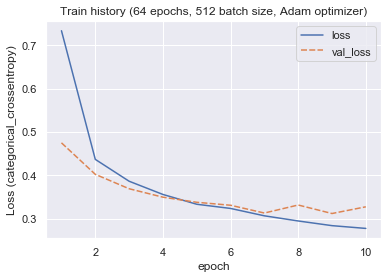

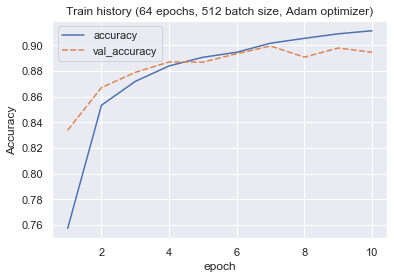

In [42]:
conv_history, best_conv_model = train(conv_model, X_train, Y_train, X_val, Y_val)

In [43]:
strftime('%X')

'16:57:18'

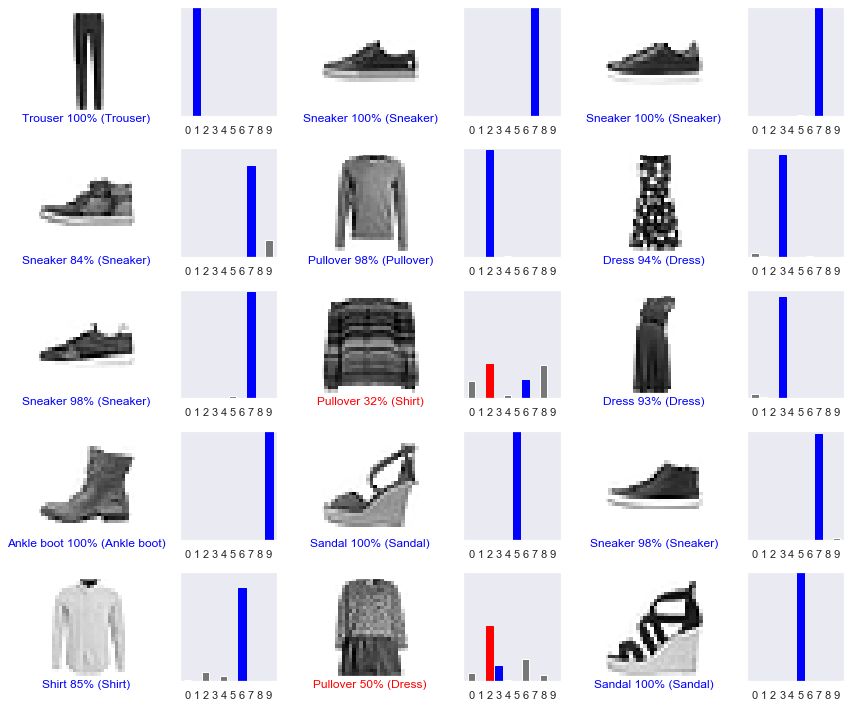

In [44]:
Y_val_conv_pred = best_conv_model.predict(X_val)
plot_image_with_prediction(X_val, ys_val, Y_val_conv_pred)

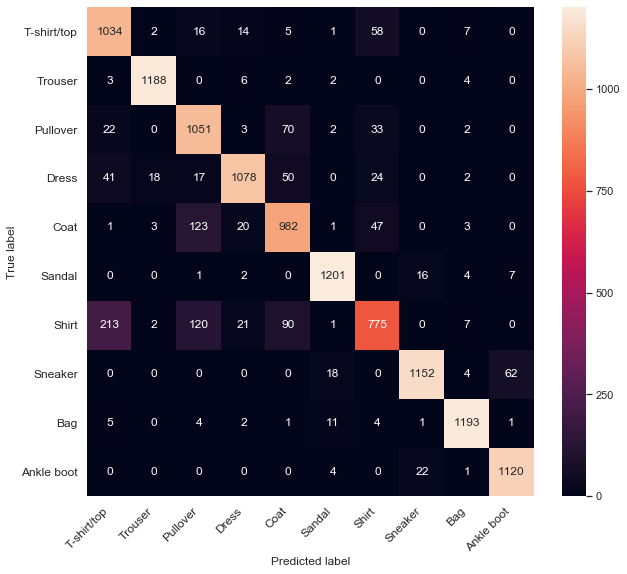

In [45]:
print_cm(ys_val, np.argmax(Y_val_conv_pred, axis=1), CLASS_NAME)

## 2. Using PCA
Re-do the ﬁrst experiment considering the PCA dimensionality reduction. Consider three diﬀerent energies (variance) for reducing the image dimensionality. What are the conclusions when using PCA in this problem? Does the accuracy improve?

In [64]:
from sklearn.decomposition import PCA

In [65]:
def print_info(array, name):
    print(f"{name+':':<9} {array.dtype.name:<7} {str(array.shape):<12} "
          f"| min: {array.min():>5.2f} | max: {array.max():>5.2f} "
          f"| mean: {array.mean():>5.3f} | std: {array.std():>5.3f}")

In [66]:
print_info(X_train, "X_train")
print_info(xs_train, "xs_train")
print_info(Y_train, "Y_train")
print_info(ys_train, "ys_train")

X_train:  float32 (48000, 784) | min: -0.81 | max:  2.02 | mean: 0.000 | std: 1.000
xs_train: float32 (48000, 784) | min:  0.00 | max:  1.00 | mean: 0.286 | std: 0.353
Y_train:  float64 (48000, 10)  | min:  0.00 | max:  1.00 | mean: 0.100 | std: 0.300
ys_train: int64   (48000,)     | min:  0.00 | max:  9.00 | mean: 4.495 | std: 2.879


_As we'll be reducing the amount of features (dimensions) of our input data after applying PCA, it makes more sense to treat it as a vector, instead of as an image.
Thus, we'll use our MLP baseline model instead of our CNN, even though the latter showed better results._

In [67]:
def build_pca_model(min_explained_variance, model_name):
    pca = PCA(min_explained_variance)
    pca.fit(X_train) # fit on train data (and then use it to transform both train and validation)
    print(pca)
    print()
    
    explained_variance = pca.explained_variance_ratio_.sum()
    print(f"{pca.n_components_} principal components → {explained_variance} explained variance")
    print(f"{pca.n_components_} / {X_train.shape[1]} = {(100 * pca.n_components_ / X_train.shape[1]):.2f}% of components used")
    
    model_pca = keras.Sequential([
        Input(shape=(pca.n_components_, )), # number of components used to keep min_explained_variance
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax', kernel_regularizer=l2(0.001))
    ], model_name)
    
    model_pca.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
    
    return model_pca, pca

In [68]:
def train_pca_model(model_pca, pca):
    history_pca, best_model_pca = train(model_pca, 
                                        pca.transform(X_train), Y_train, 
                                        pca.transform(X_val), Y_val)

    # using ys_val below, instead of np.argmax(Y_val, axis=1), simply for convinence

    Y_val_pca_pred = best_model_pca.predict(pca.transform(X_val))
    plot_image_with_prediction(X_val, ys_val, Y_val_pca_pred)

    print_cm(ys_val, np.argmax(Y_val_pca_pred, axis=1), CLASS_NAME)
    
    return Y_val_pca_pred

## 2.1. 99% explained variance

In [69]:
model_99var, pca_99var = build_pca_model(min_explained_variance=0.99, model_name="MLP_99var")

PCA(copy=True, iterated_power='auto', n_components=0.99, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

458 principal components → 0.9900491833686829 explained variance
458 / 784 = 58.42% of components used


Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 7s 152us/sample - loss: 0.7847 - accuracy: 0.7496 - val_loss: 0.4490 - val_accuracy: 0.8471
Epoch 2/64
48000/48000 [==============================] - 6s 127us/sample - loss: 0.3936 - accuracy: 0.8668 - val_loss: 0.3903 - val_accuracy: 0.8698
Epoch 3/64
48000/48000 [==============================] - 8s 167us/sample - loss: 0.3352 - accuracy: 0.8878 - val_loss: 0.3684 - val_accuracy: 0.8744
Epoch 4/64
48000/48000 [==============================] - 7s 151us/sample - loss: 0.2987 - accuracy: 0.9008 - val_loss: 0.3534 - val_accuracy: 0.8808
Epoch 5/64
48000/48000 [==============================] - 7s 148us/sample - loss: 0.2696 - accuracy: 0.9114 - val_loss: 0.3483 - val_accuracy: 0.8841
Epoch 6/64
48000/48000 [==============================] - 7s 151us/sample - loss: 0.2459 - accuracy: 0.9213 - val_loss: 0.3413 - val_accuracy: 0.8838
Epoch 7/64
48000/48000 [=====

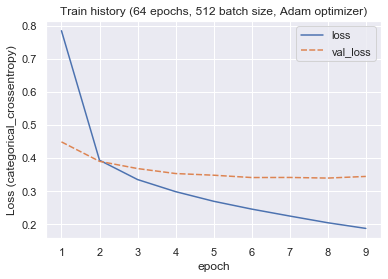

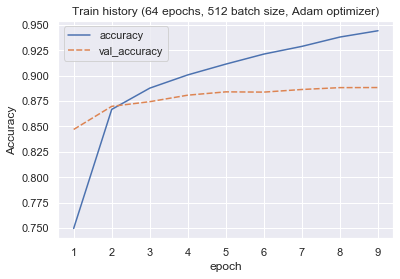

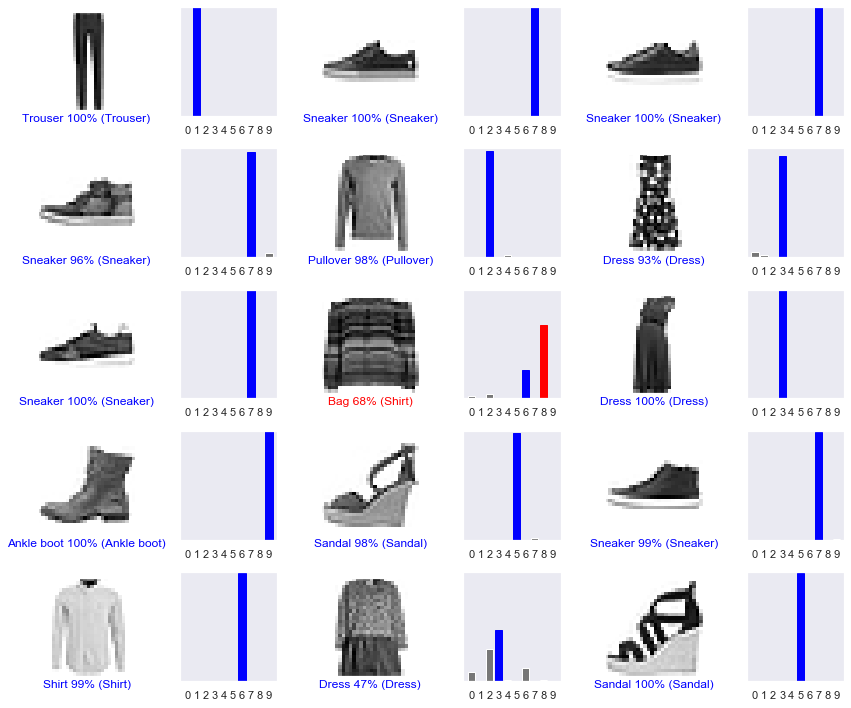

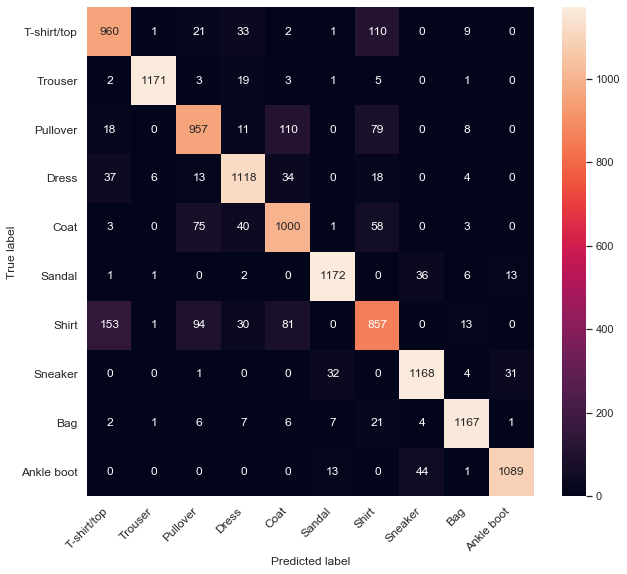

In [70]:
Y_val_99var_pred = train_pca_model(model_99var, pca_99var)

## 2.2. 95% explained variance

In [71]:
model_95var, pca_95var = build_pca_model(min_explained_variance=0.95, model_name="MLP_95var")

PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

187 principal components → 0.9501577615737915 explained variance
187 / 784 = 23.85% of components used


Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 7s 149us/sample - loss: 0.8237 - accuracy: 0.7363 - val_loss: 0.4685 - val_accuracy: 0.8438
Epoch 2/64
48000/48000 [==============================] - 7s 140us/sample - loss: 0.4188 - accuracy: 0.8595 - val_loss: 0.4054 - val_accuracy: 0.8665
Epoch 3/64
48000/48000 [==============================] - 7s 136us/sample - loss: 0.3657 - accuracy: 0.8767 - val_loss: 0.3757 - val_accuracy: 0.8730
Epoch 4/64
48000/48000 [==============================] - 6s 132us/sample - loss: 0.3347 - accuracy: 0.8860 - val_loss: 0.3581 - val_accuracy: 0.8788
Epoch 5/64
48000/48000 [==============================] - 5s 113us/sample - loss: 0.3110 - accuracy: 0.8956 - val_loss: 0.3497 - val_accuracy: 0.8801
Epoch 6/64
48000/48000 [==============================] - 5s 114us/sample - loss: 0.2924 - accuracy: 0.9028 - val_loss: 0.3413 - val_accuracy: 0.8847
Epoch 7/64
48000/48000 [=====

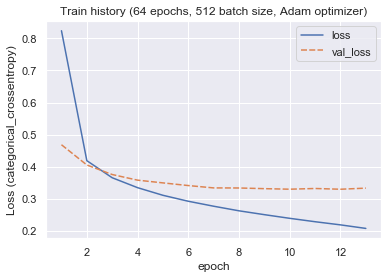

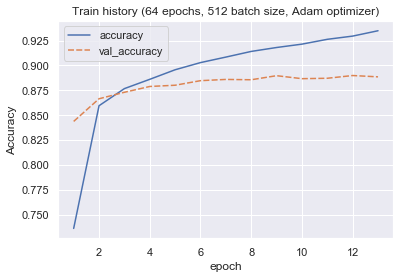

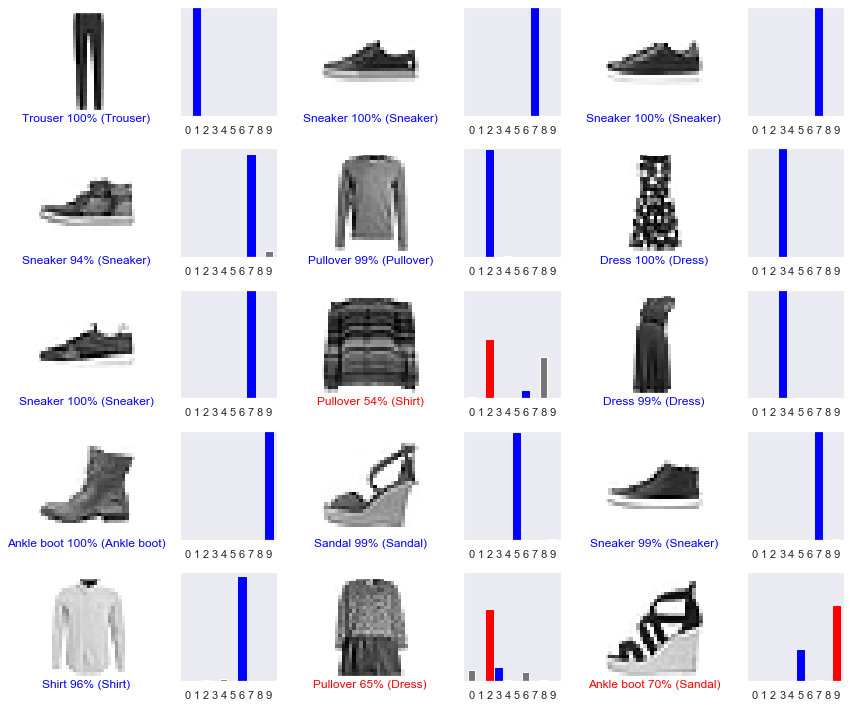

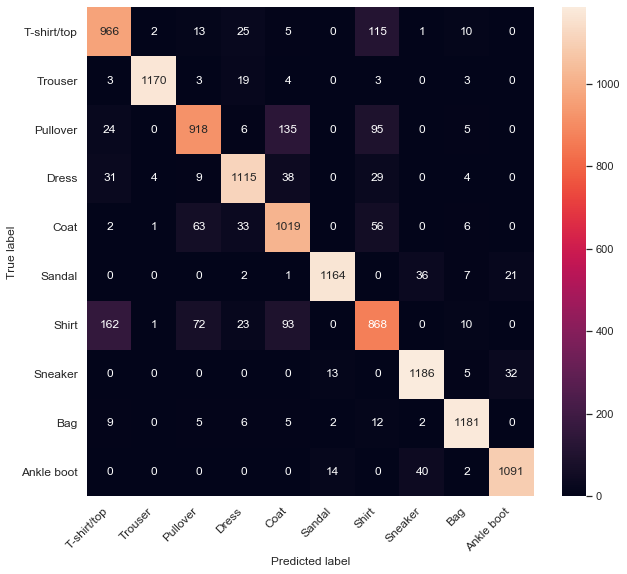

In [72]:
Y_val_95var_pred = train_pca_model(model_95var, pca_95var)

## 2.3. 90% explained variance

In [73]:
model_90var, pca_90var = build_pca_model(min_explained_variance=0.90, model_name="MLP_90var")

PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

84 principal components → 0.9006991386413574 explained variance
84 / 784 = 10.71% of components used


In [ ]:
Y_val_90var_pred = train_pca_model(model_90var, pca_90var)

Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 5s 105us/sample - loss: 0.8017 - accuracy: 0.7316 - val_loss: 0.4859 - val_accuracy: 0.8347
Epoch 2/64
48000/48000 [==============================] - 6s 122us/sample - loss: 0.4389 - accuracy: 0.8492 - val_loss: 0.4197 - val_accuracy: 0.8568
Epoch 3/64
48000/48000 [==============================] - 5s 104us/sample - loss: 0.3893 - accuracy: 0.8676 - val_loss: 0.3947 - val_accuracy: 0.8660
Epoch 4/64
48000/48000 [==============================] - 5s 103us/sample - loss: 0.3631 - accuracy: 0.8761 - val_loss: 0.3768 - val_accuracy: 0.8707
Epoch 5/64
48000/48000 [==============================] - 5s 99us/sample - loss: 0.3432 - accuracy: 0.8821 - val_loss: 0.3669 - val_accuracy: 0.8733
Epoch 6/64
48000/48000 [==============================] - 6s 122us/sample - loss: 0.3290 - accuracy: 0.8880 - val_loss: 0.3609 - val_accuracy: 0.8762
Epoch 7/64
48000/48000 [======

## 2.4. F1-scores

In [59]:
from sklearn.metrics import precision_recall_fscore_support

In [60]:
def print_f1_scores(ys, ys_pred, class_name_dict=CLASS_NAME):
    # ref.: https://github.com/erikperillo/ml-2sem2019/
    def harmonic_mean_of_positive_values(values, eps=1e-18):
        return len(values) / sum(1 / max(v, eps) for v in values)
    
    precision, recall, f1_score, _ = precision_recall_fscore_support(ys, ys_pred)
    print("                       Precision    Recall    F1-score")
    for i, (p, r, f1) in enumerate(zip(precision, recall, f1_score)):
        print(f"Class {i} {f'({class_name_dict[i]}):':<16} {p:.4f}  |  {r:.4f}  |  {f1:.4f}")
    print()
    print(f"Combined F1 score:  {len(f1_score) / sum(1 / max(v, 1e-18) for v in f1_score):.4f}")
    print(f"Combined Precision: {len(precision) / sum(1 / max(v, 1e-18) for v in precision):.4f}")
    print(f"Combined Recall:    {len(recall) / sum(1 / max(v, 1e-18) for v in recall):.4f}")

In [61]:
# MLP baseline
print_f1_scores(ys_val, np.argmax(Y_val_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.8426  |  0.8100  |  0.8260
Class 1 (Trouser):       0.9890  |  0.9726  |  0.9808
Class 2 (Pullover):      0.8449  |  0.7735  |  0.8076
Class 3 (Dress):         0.8796  |  0.9203  |  0.8995
Class 4 (Coat):          0.8211  |  0.8169  |  0.8190
Class 5 (Sandal):        0.9635  |  0.9643  |  0.9639
Class 6 (Shirt):         0.6942  |  0.7665  |  0.7285
Class 7 (Sneaker):       0.9275  |  0.9628  |  0.9448
Class 8 (Bag):           0.9743  |  0.9624  |  0.9683
Class 9 (Ankle boot):    0.9745  |  0.9337  |  0.9537

Combined F1 score:  0.8810
Combined Precision: 0.8814
Combined Recall:    0.8805


In [62]:
# CNN baseline
print_f1_scores(ys_val, np.argmax(Y_val_conv_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.7839  |  0.9094  |  0.8420
Class 1 (Trouser):       0.9794  |  0.9859  |  0.9826
Class 2 (Pullover):      0.7890  |  0.8884  |  0.8358
Class 3 (Dress):         0.9407  |  0.8764  |  0.9074
Class 4 (Coat):          0.8183  |  0.8322  |  0.8252
Class 5 (Sandal):        0.9678  |  0.9756  |  0.9717
Class 6 (Shirt):         0.8236  |  0.6306  |  0.7143
Class 7 (Sneaker):       0.9673  |  0.9320  |  0.9493
Class 8 (Bag):           0.9723  |  0.9763  |  0.9743
Class 9 (Ankle boot):    0.9412  |  0.9765  |  0.9585

Combined F1 score:  0.8875
Combined Precision: 0.8911
Combined Recall:    0.8838


In [ ]:
# 99% explained variance
print_f1_scores(ys_val, np.argmax(Y_val_99var_pred, axis=1), CLASS_NAME) # FIXME why is this worse than 95% ?

In [ ]:
# 95% explained variance
print_f1_scores(ys_val, np.argmax(Y_val_95var_pred, axis=1), CLASS_NAME)

In [ ]:
# 90% explained variance
print_f1_scores(ys_val, np.argmax(Y_val_90var_pred, axis=1), CLASS_NAME)

## 2.4. <90% explained variance

In [ ]:
RUN_LT_90var_PCA = False

## 2.4.1. 80% explained variance

In [ ]:
if RUN_LT_90var_PCA:
    model_80var, pca_80var = build_pca_model(min_explained_variance=0.80, model_name="MLP_80var")
    Y_val_80var_pred = train_pca_model(model_80var, pca_80var)
    print_f1_scores(ys_val, np.argmax(Y_val_80var_pred, axis=1), CLASS_NAME)

## 2.4.2. 60% explained variance

In [ ]:
if RUN_LT_90var_PCA:
    model_60var, pca_60var = build_pca_model(min_explained_variance=0.60, model_name="MLP_60var")
    Y_val_60var_pred = train_pca_model(model_60var, pca_60var)
    print_f1_scores(ys_val, np.argmax(Y_val_60var_pred, axis=1), CLASS_NAME)

## 2.5. Plot the first 3 principal components

Out of curiosity, let's visualize the first 2 and 3 components.

In [ ]:
pca_3pc = PCA(n_components=3)

In [ ]:
pca_3pc_result = pca_3pc.fit_transform(X_train)

In [ ]:
print(f"Explained variance per principal component:")
for i, (var, cumsum) in enumerate(zip(pca_3pc.explained_variance_ratio_, np.cumsum(pca_3pc.explained_variance_ratio_))):
    print(f"PC {i+1}: {var:.4f} (cumulative sum: {cumsum:.2f})")

In [ ]:
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x=pca_3pc_result[..., 0], # PC 1
    y=pca_3pc_result[..., 1], # PC 2
    hue="label",
    palette=sns.color_palette("hls", 10),
    data=train_dataset,
    legend="full",
    alpha=0.3
)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
# run '%matplotlib notebook' for an interactive (but laggy) visualization
ax = plt.figure(figsize=(16, 10)).gca(projection='3d')
ax.scatter(
    xs=pca_3pc_result[..., 0], # PC 1
    ys=pca_3pc_result[..., 1], # PC 2
    zs=pca_3pc_result[..., 2], # PC 3
    c=ys_train, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

## 3. Using Autoencoders
Re-do the ﬁrst experiment considering Autoencoders for reducing the image dimensionality. Consider two diﬀerent latent vector size for reducing the image dimensionality. What are the conclusions when using Autoencoders in this problem? Does accuracy improve?

Autoencoders are a branch of neural network which attempt to compress the information of the input variables into a reduced dimensional space and then recreate the input data set. Typically the autoencoder is trained over a number of iterations using gradient descent, minimizing the mean squared error. The key component is the “bottleneck” hidden layer. This is where the information from the input has been compressed. By extracting this layer from the model, each node can now be treated as a variable in the same way each chosen principal component is used as a variable in following models.


In [ ]:
from tensorflow.keras import Model
# ref.: https://blog.keras.io/building-autoencoders-in-keras.html
#       https://www.tensorflow.org/tutorials/generative/cvae

In [ ]:
def build_autoencoder(latent_dim):
    __input   = Input(shape=(784,)) # 28 * 28 = 784 pixels
    __encoded = Dense(latent_dim, activation='relu', activity_regularizer=l1(1e-4))(__input)
    __decoded = Dense(784, activation='sigmoid')(__encoded)

    autoencoder = Model(__input, __decoded)
    print("\nAutoencoder summary:")
    print(autoencoder.summary())

    encoder = Model(__input, __encoded)
    print("\nEncoder summary:")
    print(encoder.summary())

    # create a placeholder for an encoded (24-dimensional) input
    encoded_input = Input(shape=(latent_dim,))
    # retrieve the last layer of the autoencoder model
    decoder_layer = autoencoder.layers[-1]

    decoder = Model(encoded_input, decoder_layer(encoded_input))
    print("\nDecoder summary:")
    print(decoder.summary())

    autoencoder.compile(optimizer='adam', loss='mse')

    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.003, patience=3)]

    autoencoder.fit(X_train, X_train,
                    validation_data=(X_val, X_val),
                    epochs=MAX_EPOCHS,
                    batch_size=BATCH_SIZE,
                    shuffle=True,
                    callbacks=callbacks,
                    verbose=2)
    return autoencoder, encoder, decoder

In [ ]:
def show_autoencoder_sample(encoder, decoder):
    encoded_imgs = encoder.predict(X_val)
    decoded_imgs = decoder.predict(encoded_imgs)

    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(X_val[i].reshape(28, 28), cmap='binary')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='binary')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [ ]:
def train_ae_model(encoder, latent_dim, model_name):
    model = keras.Sequential([
        Input(shape=(latent_dim, )), # number of components used to keep min_explained_variance
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax', kernel_regularizer=l2(0.001))
    ], model_name)

    model.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

    history_ae, best_model_ae = train(model, 
                                      encoder.predict(X_train), Y_train, 
                                      encoder.predict(X_val), Y_val)

    # using ys_val below, instead of np.argmax(Y_val, axis=1), simply for convinence

    Y_val_ae_pred = best_model_ae.predict(encoder.predict(X_val))
    plot_image_with_prediction(X_val, ys_val, Y_val_ae_pred)

    print_cm(ys_val, np.argmax(Y_val_ae_pred, axis=1), CLASS_NAME)
    
    return Y_val_ae_pred, best_model_ae

## 3.1. Latent vector size of 84

In [ ]:
latent_dim = 84

In [ ]:
autoencoder_84, encoder_84, decoder_84 = build_autoencoder(latent_dim)

In [ ]:
show_autoencoder_sample(encoder_84, decoder_84)

In [ ]:
Y_val_ae_84_pred, model_ae_84 = train_ae_model(encoder_84, latent_dim, model_name="AE_84")

In [ ]:
print_f1_scores(ys_val, np.argmax(Y_val_ae_84_pred, axis=1), CLASS_NAME)

## 3.2. Latent vector size of 24

In [ ]:
latent_dim = 24

In [ ]:
autoencoder_24, encoder_24, decoder_24 = build_autoencoder(latent_dim)

In [ ]:
show_autoencoder_sample(encoder_24, decoder_24)

In [ ]:
Y_val_ae_24_pred, model_ae_24 = train_ae_model(encoder_24, latent_dim, model_name="AE_24")

In [ ]:
print_f1_scores(ys_val, np.argmax(Y_val_ae_24_pred, axis=1), CLASS_NAME)

## 4. Using clustering techniques
Explore two clustering algorithms using the reduced features (PCA or Autoencoders). Do the clusters make sense? Check the validity/quality of your clusters.

In [ ]:
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering
from sklearn.metrics import adjusted_rand_score

In [ ]:
strftime('%X')